<a href="https://colab.research.google.com/github/weisben/adversarial-examples/blob/main/Adv_Input_STL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Example Generator

I use FGSM to generate images to fool a ResNet trained on the STL-10 dataset.

### Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from skimage.metrics import structural_similarity as compare_ssim

### Sources

In the making of this project, I referenced this [PyTorch tutorial](https://savan77.github.io/blog/imagenet_adv_examples.html) and this [paper](https://download.arxiv.org/pdf/2009.03728v1.pdf).

## [STL-10 Dataset](https://cs.stanford.edu/~acoates/stl10/)

The STL-10 Dataset contains hundereds of thousands of 95x95 images in 10 classes. The classes are as follows:
0. airplane
1. bird
1. car
1. cat
1. deer
1. dog
1. horse
1. monkey
1. ship
1. truck

The lower resolution and small number of classes make this data set ideal for tuning a model.

In [2]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

# Datasets
dsets = {x: datasets.STL10(root='./data', split=x, download=True, transform=preprocess)
         for x in ['train', 'test']}
# Dataloaders
dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16, shuffle=(x == "train"))
               for x in ['train', 'test']}

100%|██████████| 2640397119/2640397119 [01:02<00:00, 41914499.71it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Dictionaries to go between labels (ints) and names (strings)
LABEL_TO_NAME = {0:'airplane', 1:'bird', 2:'car', 3:'cat', 4:'deer', 5:'dog', 6:'horse', 7:'monkey', 8:'ship', 9:'truck'}
NAME_TO_LABEL = {'airplane':0, 'bird':1, 'car':2, 'cat':3, 'deer':4, 'dog':5, 'horse':6, 'monkey':7, 'ship':8, 'truck':9}

## Training ResNet34

ResNet34 is an image classification model which uses deep residual connections. It is originally trained on the ImageNet dataset, which has 1000 output classes. Here, we will change the output classes to 10 for STL-10.

In [4]:
# ResNet34 with a modified last layer to allow for 10 classes
model = models.resnet34(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 99.9MB/s]


Now, we can train ResNet34 on STL-10. The training process will be relatively quick since the ResNet is already accustomed to classifying images. We will be using Cross Entropy Loss and the Adam optimizer.

In [5]:
# loss
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

num_epochs = 5

In [6]:
# Training loop from demo 5
for epoch in range(num_epochs):

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)

        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")


Epoch:0 -- Phase:train -- Loss:1.41 -- Acc:51.80
Epoch:0 -- Phase:test -- Loss:1.27 -- Acc:54.83
Epoch:1 -- Phase:train -- Loss:0.95 -- Acc:66.84
Epoch:1 -- Phase:test -- Loss:1.19 -- Acc:62.39
Epoch:2 -- Phase:train -- Loss:0.71 -- Acc:74.90
Epoch:2 -- Phase:test -- Loss:0.93 -- Acc:67.95
Epoch:3 -- Phase:train -- Loss:0.58 -- Acc:80.48
Epoch:3 -- Phase:test -- Loss:0.91 -- Acc:70.10
Epoch:4 -- Phase:train -- Loss:0.42 -- Acc:85.80
Epoch:4 -- Phase:test -- Loss:0.70 -- Acc:76.86


In [7]:
# Save parameters
torch.save(model.state_dict(), 'model_parameters.pth')

In [ ]:
# Load parameters
# model.load_state_dict(torch.load('model_parameters.pth'))

Text(0.5, 1.0, 'Accuracy')

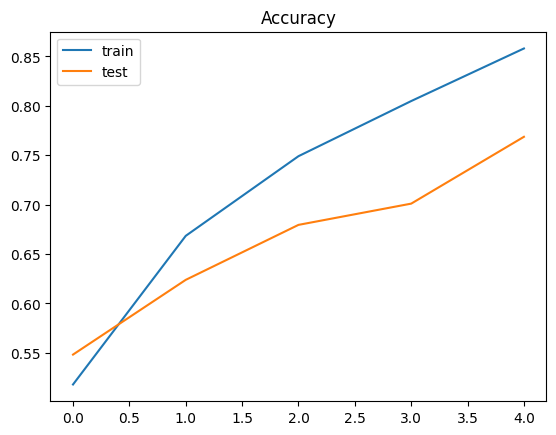

In [8]:
# Plot accuracies
plt.plot(save_acc['train'])
plt.plot(save_acc['test'])
plt.legend(["train", "test"])
plt.title("Accuracy")

## Fooling ResNet

Now, let's look at a specific image and see the different ways we can fool our image classification model.

In [9]:
images, labels = next(iter(dataloaders['test']))

In [10]:
# Change i to select a different item from the batch
i = 0
image = images[i].unsqueeze(0)
label = labels[i]

In [11]:
# Transform to unnormalize images
# from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
unNorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [12]:
def quick_classify(model, X, y):
  """Displays and image and how it is classified
  Parameters
  ----------
    model: image classification model
    X: image to be classified
    y: true label
  """
  display = np.transpose(unNorm(X.squeeze()), (1,2,0)) # UnNormalize and Transpose image for display using plt
  name = LABEL_TO_NAME[y.numpy().item()]
  plt.imshow(display, cmap="gray")
  plt.axis('off')
  plt.show()
  print(f"True Label: {name}")

  # Quickly run the model on the image to get the predicted class and probability
  X = Variable(X, requires_grad=True)
  output = model(X)
  y_hat = torch.argmax(output).detach().numpy().item()
  pred_name = LABEL_TO_NAME[y_hat]
  pred_prob = round(100 * torch.max(F.softmax(output, dim=1)).detach().numpy().item(), 2)
  print(f"Predicted: {pred_name} ({pred_prob}%)")

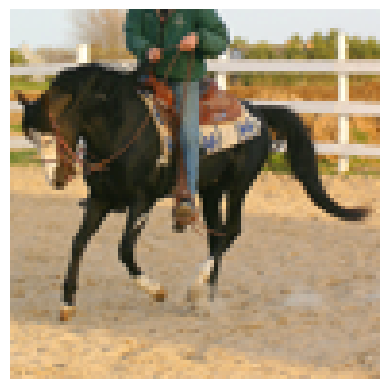

True Label: horse
Predicted: horse (99.39%)


In [13]:
quick_classify(model, image, label)

This is our image! Let's see what we can do to it.

In [14]:

def computedSSIM(tensor1, tensor2):
  """Computes structural similarity index of two tensors
  Parameters
  ----------
  tensor1, tensor2: tensors to be compared
  """
  images = []
  for tensor in [tensor1, tensor2]:
    image = unNorm(tensor) # unnormalize
    image = image.permute(1,2,0).cpu().detach().numpy() # C X H X W  ==>   H X W X C
    if len(image.shape) > 2: # Convert to grayscale
      image = np.mean(image, axis=2)
    images.append(image)

  ssim_score, _ = compare_ssim(images[0], images[1], full=True)
  return ssim_score

In [15]:
# Adapted from https://savan77.github.io/blog/imagenet_adv_examples.html
def visualize(model, X, eps, grad, adv):
  """Visualize clean image, perturbation, and resulting adversarial image
  Parameters
  ----------
    model: image classification model
    X: clean image
    eps: perturbation weight
    grad: gradient of clean image
    adv: adversarial image
  """
  ssim_index = computedSSIM(X.squeeze(0), adv.squeeze(0))
  # Compute Labels and Probabilities
  X_output = model(X)
  X_pred = LABEL_TO_NAME[torch.argmax(X_output).detach().numpy().item()]
  X_prob = round(100 * torch.max(F.softmax(X_output, dim=1)).detach().numpy().item(), 4)
  adv_output = model(adv)
  adv_pred = LABEL_TO_NAME[torch.argmax(adv_output).detach().numpy().item()]
  adv_prob = round(100 * torch.max(F.softmax(adv_output, dim=1)).detach().numpy().item(), 4)
  # Original Image
  X = X.squeeze(0)
  X = unNorm(X) # unnormalize
  X = np.transpose(X, (1,2,0)) # C X H X W  ==>   H X W X C
  X = np.clip(X, 0, 1)
  # Gradient
  grad = grad.squeeze(0).numpy()
  grad = np.transpose(grad, (1,2,0))
  grad = np.clip(grad, 0, 1)
  # Adversarial Image
  adv = adv.squeeze(0)
  adv = unNorm(adv)
  adv = np.transpose(adv , (1,2,0))
  adv = np.clip(adv, 0, 1)

  # Plot
  figure, ax = plt.subplots(1,3, figsize=(18,8))
  ax[0].imshow(X)
  ax[0].set_title('Clean Example', fontsize=20)
  ax[1].imshow(grad)
  ax[1].set_title('Perturbation', fontsize=20)
  ax[2].imshow(adv)
  ax[2].set_title('Adversarial Example', fontsize=20)
  ax[0].axis('off')
  ax[1].axis('off')
  ax[2].axis('off')
  ax[0].text(1.1,0.5, "+{}*".format(round(eps,3)), size=15, ha="center",
            transform=ax[0].transAxes)
  ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(X_pred, X_prob), size=15, ha="center",
        transform=ax[0].transAxes)
  ax[1].text(0.5,-0.13, "SSIM Index: {}".format(round(ssim_index, 3)), size=15, ha="center",
        transform=ax[1].transAxes)
  ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)
  ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center",
        transform=ax[2].transAxes)
  plt.show()

### Fast Gradient Sign Method (FGSM)

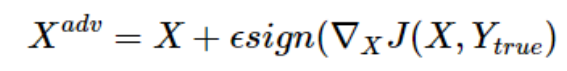

A very simple way to fool our image classification model is FGSM. Here, we input an image and calculate the sign of the gradient of the loss for that image. Then, we shift the image by that amount multiplied by a small value epsilon. Essentially, we are slightly altering each pixel in the image in the direction of the gradient, so that the loss will go up.

Note: The following functions were built with the help of https://savan77.github.io/blog/imagenet_adv_examples.html, and then improved/simplified.

In [16]:
def FGSM(model, X, y, eps):
  """Performs FGSM on a clean image and returns a corresponding adversarial image
  Parameters
  ----------
    model: image classification model
    X: clean image
    y: true label
    eps: perturbation weight

  Returns
  -------
    X_adv: adversarial image
    X_grad_sign: sign of gradient of clean image
  """
  # Find loss of image
  X = Variable(X, requires_grad=True)
  output = model(X)
  target = Variable(torch.LongTensor([y]), requires_grad=False)
  criterion = torch.nn.CrossEntropyLoss()
  loss = criterion(output, target)
  loss.backward()

  # Follow the function above to find X_adv
  X_grad_sign = torch.sign(X.grad.data)
  X_adv = X.data + eps * X_grad_sign

  return X_adv, X_grad_sign

In [17]:
def FGSM_batch(model, inputs, labels, eps):
  """Performs FGSM on a batch of clean images and returns a batch of adversarial images
  Parameters
  ----------
    model: image classification model
    X: clean image
    y: true label
    eps: perturbation weight

  Returns
  -------
    inputs_adv: batch of adversarial images
    grads: list of gradients of clean images
  """
  # Find loss of image
  inputs = [Variable(X, requires_grad=True) for X in inputs]
  outputs = model(inputs)
  targets = [Variable(torch.LongTensor([y]), requires_grad=False) for y in labels]
  criterion = torch.nn.CrossEntropyLoss()

  inputs_adv = []
  grads = []
  for input, output, target in zip(inputs, outputs, targets):
    print(target)
    loss = criterion(output.unsqueeze(0), target)
    loss.backward()
    grad_sign = torch.sign(input.grad.data)
    input_adv = input.data + eps * grad_sign
    inputs_adv.append(input_adv)
    grads.append(grad_sign)

  return inputs_adv, grads

Let's try using FGSM on our example image.

In [18]:
epsilon = 0.1
adv, grad = FGSM(model, image, label, epsilon)

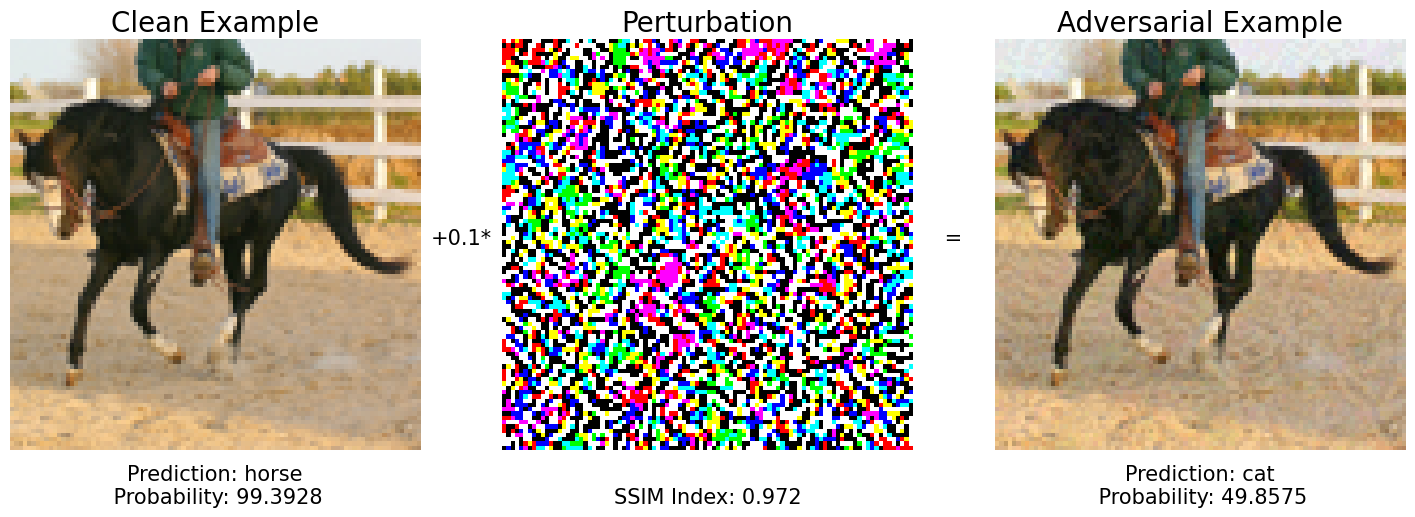

In [19]:
visualize(model, image, epsilon, grad, adv)

We can compare between the clean and adversarial example to see that there are some small changes apparent. However, if all we saw was the adversarial image, it is likely that we wouldn't know that the image had been tampered with. Indeed, it only looks like a slightly noised version of the clean image. However, we know from the above equation that the noise has been very deliberately chosen in order to fool the image classification model.

### FGSM Targeted

We can also do FGSM with a target class in mind. All that we change is the loss function that we compute the gradient of: we compute the cross entropy loss where the relevant class is now the target class $t$. Then, we alter the image in the direction of the gradient with respect to that loss, hopefully encouraging the model to classify it more as class $t$.

In [20]:
def targetedFGSM(model, X, t, eps):
  """Performs targeted FGSM on a clean image and returns a corresponding adversarial image
  Parameters
  ----------
    model: image classification model
    X: clean image
    t: target label
    eps: perturbation weight

  Returns
  -------
    X_adv: adversarial image
    X_grad_sign: sign of gradient of clean image
  """
  # Fwd pass on clean
  X = Variable(X, requires_grad=True)
  output = model(X)
  target = Variable(torch.LongTensor([t]), requires_grad=False)
  criterion = torch.nn.CrossEntropyLoss()
  loss = -criterion(output, target) # notice that this has changed to negative - remember that we want to maximize this loss, not minimize
  loss.backward(retain_graph=True)

  # Equation
  X_grad_sign = torch.sign(X.grad.data)
  X_adv = X.data + eps * X_grad_sign

  return X_adv, X_grad_sign

Let's try it on our example image. Note that we can change the label below to be any class of the 10.

In [21]:
target_class = "truck"
target_label = NAME_TO_LABEL[target_class]
epsilon = 0.05
adv, grad = targetedFGSM(model, image, target_label, epsilon)

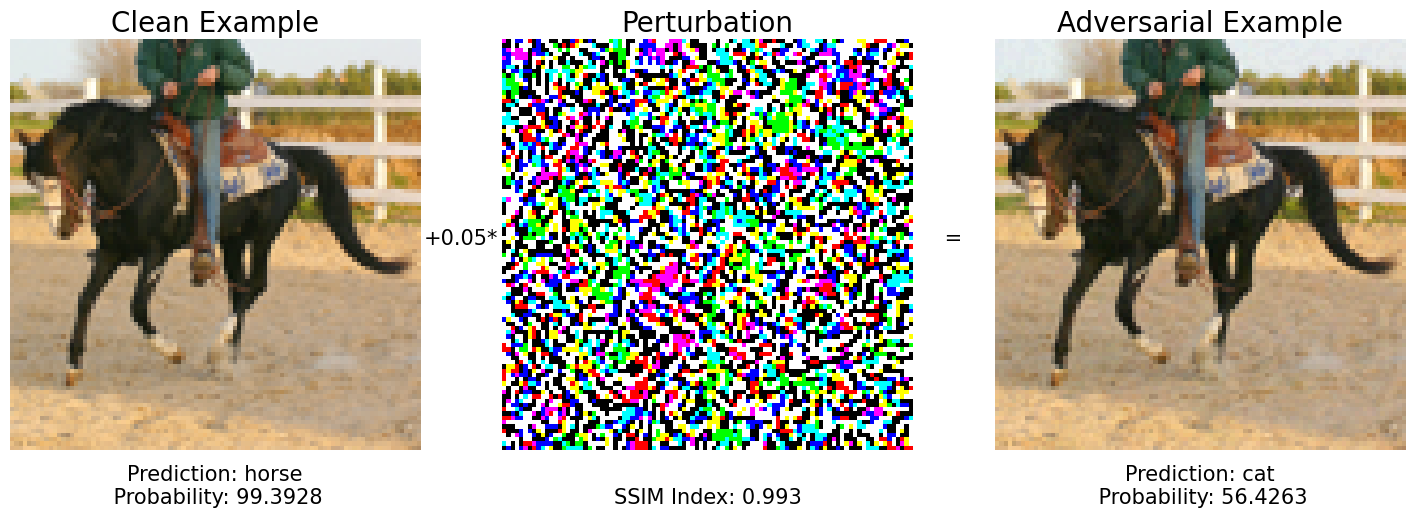

In [22]:
visualize(model, image, epsilon, grad, adv)

The targeted approach is not the best for standard FGSM. We will see it work better when we introduce our next tool.

### Iterative FGSM

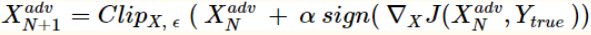

If we want to get even better results, we can improve our approach through iteration. Instead of taking one big step in the direction of the gradient, we can take several small steps - looking at the gradient each time.

In [23]:
def iterFGSM(model, X, y, eps, alpha, num_steps):
  """Performs iterative FGSM on a clean image and returns a corresponding adversarial image
  Parameters
  ----------
    model: image classification model
    X: clean image
    y: true label
    eps: perturbation weight
    alpha: iteration step weight
    num_steps: number of iterations

  Returns
  -------
    X_adv: adversarial image
    X_grad_sign: sign of gradient of clean image
  """
  output = model(X)
  target = Variable(torch.LongTensor([y]), requires_grad=False)

  criterion = torch.nn.CrossEntropyLoss()

  X_adv = Variable(X, requires_grad=True)
  total_grad = 0
  for _ in range(num_steps):
    if X_adv.grad is not None: X_adv.grad.zero_()
    # Forward
    output_adv = model(X_adv)
    loss = criterion(output_adv, target)
    # Backward
    loss.backward()
    # Formula
    total_grad = X_adv.data - X.data + alpha * torch.sign(X_adv.grad.data)
    total_grad = torch.clamp(total_grad, -eps, eps)
    X_adv.data = X.data + total_grad

  return X_adv.data, torch.sign(X_adv.grad.data)

Let'ss try iterative FGSM on our example image.

In [26]:
# hyperparameters
epsilon = 0.05
num_steps = 10
alpha = 0.025
adv, grad = iterFGSM(model, image, label, epsilon, alpha, num_steps)

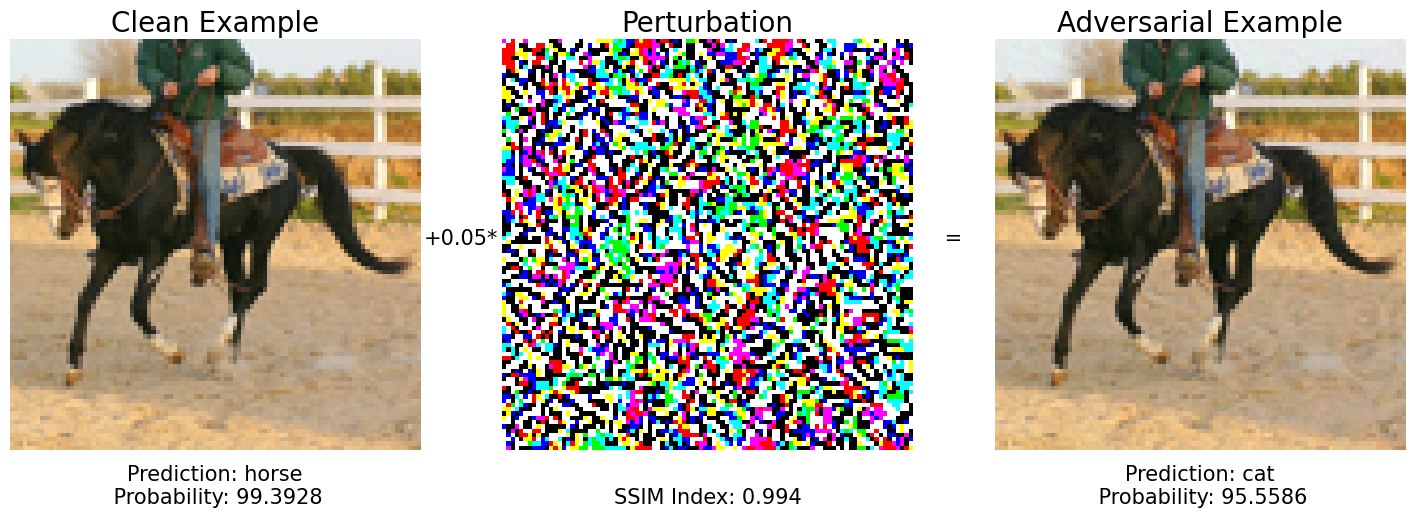

In [27]:
visualize(model, image, epsilon, grad, adv)

The iterative approach generally allows us to fool the model using lower values of epsilon. This is because we are making multiple smaller changes to the image, each of which is more "accurate."

### Iterative FGSM Targeted

Lastly, we can combine two approaches: iterative FGSM with a target class.

In [28]:
def targetedIterFGSM(model, X, t, eps, alpha, num_steps):
  """Performs targeted iterative FGSM on a clean image and returns a corresponding adversarial image
  Parameters
  ----------
    model: image classification model
    X: clean image
    t: target label
    eps: perturbation weight
    alpha: iteration step weight
    num_steps: number of iterations

  Returns
  -------
    X_adv: adversarial image
    X_grad_sign: sign of gradient of clean image
  """
  output = model(X)
  target = Variable(torch.LongTensor([t]), requires_grad=False)

  criterion = torch.nn.CrossEntropyLoss()

  X_adv = Variable(X, requires_grad=True)
  total_grad = 0
  for _ in range(num_steps):
    if X_adv.grad is not None: X_adv.grad.zero_()
    # Forward
    output_adv = model(X_adv)
    loss = -criterion(output_adv, target) # note the negated loss again
    # Backward
    loss.backward()

    # Formula
    total_grad = X_adv.data + alpha * torch.sign(X_adv.grad.data) - X.data
    total_grad = torch.clamp(total_grad, -eps, eps)
    X_adv.data = X.data + total_grad

  return X_adv.data, torch.sign(total_grad)


Let's try it on our example image.

In [42]:
# hyperparameters
epsilon = 0.05
num_steps = 20
alpha = 0.025
target_class = "airplane"
target_label = NAME_TO_LABEL[target_class]
adv, grad = iterFGSM(model, image, target_label, epsilon, alpha, num_steps)

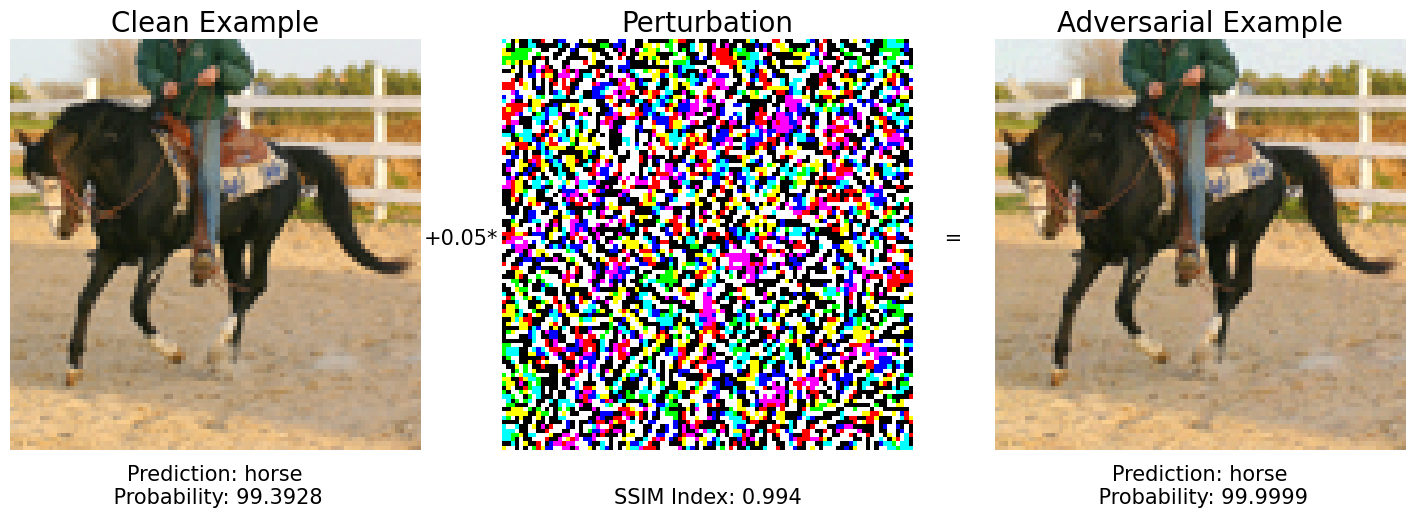

In [43]:
visualize(model, image, epsilon, grad, adv)

The iterative approach works better than the non-iterative approach when we are using a target class. However, it will still sometimes fail.

## Statistical Analysis
Let's look at how well these functions perform. We will compare the confusion matrices for the model on the clean test set and a test set modified by targeted iterative FGSM.

In [44]:
def print_confusion_matrix(matrix):
    print("Confusion Matrix: Rows are True Class and Columns are Predicted Class")
    max_length = max(len(str(element)) for row in matrix for element in row)
    row_format = " | ".join([f"{elem:>{max_length}}" for elem in matrix[0]])
    print("-" * len(row_format))
    for row in matrix:
        print(" | ".join([f"{elem:>{max_length}}" for elem in row]))
        print("-" * len(row_format))

In [52]:
def test_acc(model, num_batches=10, isAdv=False):
  matrix = [[0 for j in range(10)] for i in range(10)]
  total_num = 0
  num_correct = 0
  total_ssim = 0

  for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
      # End condition
      if batch_idx >= num_batches:
        accuracy = num_correct.numpy() / total_num
        avg_ssim = total_ssim / total_num
        return accuracy, matrix, avg_ssim

      with torch.set_grad_enabled(True):

        if isAdv:
          inputs_adv = []
          for input, label in zip(inputs, labels):
            # Apply perturbation
            adv, _ = targetedIterFGSM(model, input.unsqueeze(0), 0, 0.1, 0.025, 10)
            adv = adv.squeeze(0)
            inputs_adv.append(adv)
            # Compute ssim
            total_ssim += computedSSIM(input, adv)
          inputs_adv = torch.stack(inputs_adv)
          outputs = model(inputs_adv)

        else: outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        for i in range(len(preds)):
          matrix[labels[i]][preds[i]] += 1
        total_num += len(preds)
        num_correct += torch.sum(preds == labels.data)

To speed up the comparison, we will not do this on the whole test set. This is because generating these adversarial images is quite computationally costly.

In [53]:
num_batches = 10
acc, matrix, _ = test_acc(model, num_batches)
acc_adv, matrix_adv, avg_ssim = test_acc(model, num_batches, isAdv=True)

In [54]:
print("Original Accuracy: " + str(acc) + "\nAdversarial Accuracy: " + str(acc_adv))

Original Accuracy: 0.7083333333333334
Adversarial Accuracy: 0.13194444444444445


In [55]:
print("Clean Confusion Matrix")
print_confusion_matrix(matrix)

Clean Confusion Matrix
Confusion Matrix: Rows are True Class and Columns are Predicted Class
-----------------------------------------------
16 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  1 |  0
-----------------------------------------------
 2 | 14 |  0 |  1 |  2 |  2 |  0 |  4 |  0 |  1
-----------------------------------------------
 0 |  0 | 11 |  1 |  0 |  0 |  0 |  0 |  0 |  0
-----------------------------------------------
 1 |  0 |  0 | 12 |  1 |  0 |  0 |  1 |  0 |  0
-----------------------------------------------
 0 |  2 |  1 |  3 |  7 |  0 |  1 |  0 |  0 |  0
-----------------------------------------------
 0 |  1 |  0 |  2 |  0 |  7 |  2 |  3 |  1 |  0
-----------------------------------------------
 0 |  0 |  0 |  0 |  0 |  0 |  9 |  0 |  0 |  0
-----------------------------------------------
 0 |  0 |  0 |  1 |  0 |  1 |  1 | 12 |  0 |  0
-----------------------------------------------
 1 |  0 |  1 |  0 |  0 |  0 |  0 |  0 |  8 |  0
-------------------------------------------

In [56]:
print("Adversarial Confusion Matrix")
print_confusion_matrix(matrix_adv)
print("Average SSIM: " + str(avg_ssim))

Adversarial Confusion Matrix
Confusion Matrix: Rows are True Class and Columns are Predicted Class
-----------------------------------------------
17 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0
-----------------------------------------------
26 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0
-----------------------------------------------
11 |  0 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |  0
-----------------------------------------------
15 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0
-----------------------------------------------
13 |  0 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |  0
-----------------------------------------------
16 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0
-----------------------------------------------
 9 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0
-----------------------------------------------
14 |  0 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |  0
-----------------------------------------------
10 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0
-------------------------------------